In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf


In [2]:

PATH='/home/falko/tensorflow_projekte/mnist/'

train_data=pd.read_csv(PATH+"data/train.csv")#
test_data=pd.read_csv(PATH+"data/test.csv")#

%matplotlib inline


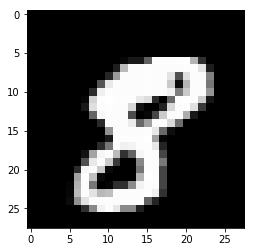

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(train_data.iloc[10,1:].values.reshape((28, 28)),cmap='gray')

In [8]:
train_data.iloc[:,0].values

array([1, 0, 1, ..., 7, 6, 9])

In [6]:
# Train - Test Split of training-data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,1:], train_data.iloc[:,0], test_size=0.20, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf_rf = RandomForestClassifier(max_depth=10, n_estimators=400, min_samples_split=4, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred=clf_rf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       816
          1       0.96      0.99      0.98       909
          2       0.95      0.94      0.94       846
          3       0.95      0.91      0.93       937
          4       0.94      0.94      0.94       839
          5       0.95      0.93      0.94       702
          6       0.96      0.98      0.97       785
          7       0.95      0.92      0.94       893
          8       0.94      0.93      0.94       835
          9       0.88      0.93      0.90       838

avg / total       0.95      0.95      0.95      8400



In [27]:
test_data_pred=clf_rf.predict(test_data)

In [33]:
pd.DataFrame({'ImageId':range(1,28001), 'Label': test_data_pred}).to_csv(PATH+"data/submit.csv", index=False)

In [5]:

# Feature columns describe how to use the input.
my_feature_columns = []
for key in X_train.columns:
    my_feature_columns.append(tf.feature_column.numeric_column(key=key, dtype=tf.float32))

In [6]:
def my_model(features, labels, mode, params):
    
    """
    net = tf.feature_column.input_layer(features, params['feature_columns'])
    for units in params['hidden_units']:
        net = tf.layers.dense(net, units=units, activation=tf.nn.relu)

    # Compute logits (1 per class).
    logits = tf.layers.dense(net, params['n_classes'], activation=None)
    
    """
    #CNN:
    
    # Input Layer
    input_layer = tf.feature_column.input_layer(features,  params["feature_columns"])
    input_layer = tf.reshape(input_layer, [-1, 28, 28, 1])
    #input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
  # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
  # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
    inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    
    

    # Compute predictions.
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Compute loss.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)


In [16]:


#  mnist_classifier = tf.estimator.Estimator(
#model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

classifier = tf.estimator.Estimator(
    model_fn=my_model,
    params={
        'feature_columns': my_feature_columns,
    },
    model_dir=PATH + "models/model_dir9")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/falko/tensorflow_projekte/mnist/models/model_dir9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f172a302f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((features.to_dict('list'), labels))


    # Shuffle, repeat, and batch the examples.
    #return dataset.shuffle(1000).repeat().batch(batch_size)
    return dataset.batch(batch_size)




In [18]:
# Train the Model.
classifier.train(input_fn=lambda:train_input_fn(X_train, y_train.values,100),steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /home/falko/tensorflow_projekte/mnist/models/model_dir9/model.ckpt.
INFO:tensorflow:loss = 38.235985, step = 1
INFO:tensorflow:global_step/sec: 2.37762
INFO:tensorflow:loss = 0.75521064, step = 101 (42.060 sec)
INFO:tensorflow:global_step/sec: 3.10468
INFO:tensorflow:loss = 0.494776, step = 201 (32.209 sec)
INFO:tensorflow:global_step/sec: 3.19383
INFO:tensorflow:loss = 0.5865511, step = 301 (31.310 sec)
INFO:tensorflow:Saving checkpoints for 336 into /home/falko/tensorflow_projekte/mnist/models/model_dir9/model.ckpt.
INFO:tensorflow:Loss for final step: 0.28326783.


In [19]:
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

In [20]:
eval_result = classifier.evaluate(input_fn=lambda:eval_input_fn(X_test.to_dict('list'), y_test,100))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-04-06:26:31
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/falko/tensorflow_projekte/mnist/models/model_dir9/model.ckpt-336
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-04-06:26:46
INFO:tensorflow:Saving dict for global step 336: accuracy = 0.9234524, global_step = 336, loss = 0.25382265


In [21]:
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.923



In [22]:
predictions = classifier.predict(
        input_fn=lambda:eval_input_fn(test_data,
                                                labels=None,
                                                batch_size=100))

In [14]:
    out=[]
    for pred_dict in (predictions):
        out.append(pred_dict['class_ids'][0])
        #print(pred_dict['probabilities'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/falko/tensorflow_projekte/mnist/models/model_dir8/model.ckpt-672
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [15]:
pd.DataFrame({'ImageId':range(1,28001), 'Label':out}).to_csv(PATH+"data/submit_tf.csv", index=False)